<a href="https://colab.research.google.com/github/rbbh/SVR-PSO/blob/master/SVR_%2B_PSO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import numpy as np
import matplotlib.pyplot as plt
import sys
from sklearn import svm
from mpl_toolkits.mplot3d import axes3d, Axes3D

In [3]:
from google.colab import files
uploaded = files.upload()

Saving airlines2.txt to airlines2.txt


In [0]:
import io
import pandas as pd
data = pd.read_csv(io.BytesIO(uploaded['airlines2.txt']))
#data = pd.read_csv(io.BytesIO(uploaded['DadosONS.txt']))

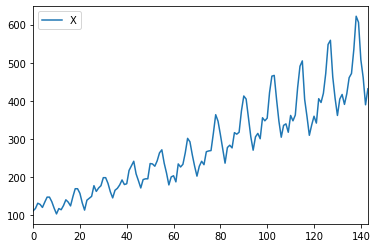

In [5]:
data.plot()


In [6]:
# Lag used for the prediction
# We will use 12 for the lag because 
# the series repeats itself annually

dimensions = 12
data_c = pd.concat([data.shift(i) for i in range(0 + dimensions + 1)], axis = 1)
print(data_c)

       X      X      X      X      X  ...      X      X      X      X      X
0    112    NaN    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
1    118  112.0    NaN    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
2    132  118.0  112.0    NaN    NaN  ...    NaN    NaN    NaN    NaN    NaN
3    129  132.0  118.0  112.0    NaN  ...    NaN    NaN    NaN    NaN    NaN
4    121  129.0  132.0  118.0  112.0  ...    NaN    NaN    NaN    NaN    NaN
..   ...    ...    ...    ...    ...  ...    ...    ...    ...    ...    ...
139  606  622.0  535.0  472.0  461.0  ...  405.0  362.0  407.0  463.0  559.0
140  508  606.0  622.0  535.0  472.0  ...  417.0  405.0  362.0  407.0  463.0
141  461  508.0  606.0  622.0  535.0  ...  391.0  417.0  405.0  362.0  407.0
142  390  461.0  508.0  606.0  622.0  ...  419.0  391.0  417.0  405.0  362.0
143  432  390.0  461.0  508.0  606.0  ...  461.0  419.0  391.0  417.0  405.0

[144 rows x 13 columns]


In [0]:
# Normalizing the data

data_c = data_c/data_c.max() 

In [8]:
# Splitting the data into train, validation and test

from sklearn.model_selection import train_test_split

X = data_c.iloc[12:,1:]
y = data_c.iloc[12:,0]

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4, shuffle = False)

X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5, shuffle = False)


print(len(y_val))
print(len(y_test))
print(len(y_train))



26
27
79


In [0]:
# Function that displays tridimensional plot
def plot(some_list):
  ax = Axes3D(plt.figure())
  ax.scatter3D(some_list[:,0], some_list[:,1], some_list[:,2], color = 'r')
  ax.set_xlabel('$C$', fontsize = 20)
  ax.set_ylabel('$\epsilon$', fontsize = 25)
  ax.zaxis.set_rotate_label(False) 
  ax.set_zlabel('$\gamma$', fontsize=30, rotation = 0)
  ax.zaxis._axinfo['label']['space_factor'] = 1.0
  plt.show()

In [0]:
def pso(n_particles, iterations, dimensions, inertia):

    # Range of SVR's hyperparameters (Particles' search space)
    # C, Epsilon and Gamma
    max_c = 1e4
    min_c = 1e-1
    max_e = 1e-1
    min_e = 1e-4
    max_g = 1e0
    min_g = 1e-3
    
    x = np.random.rand(n_particles, 1)*(max_c - min_c) + min_c
    y = np.random.rand(n_particles, 1)*(max_e - min_e) + min_e
    z = np.random.rand(n_particles, 1)*(max_g - min_g) + min_g

    c = np.concatenate((x,y,z), axis=1)

    # Initializing particles's parameters
    v = np.zeros((n_particles, dimensions))
    c1 = 2
    c2 = 2
    p_best = np.zeros((n_particles, dimensions))
    p_best_val = np.zeros(n_particles) + sys.maxsize
    g_best = np.zeros(dimensions)
    g_best_val = sys.maxsize

    # TODO: Create function for thresholds
    threshold = 10e100
    threshold2 = 10e100
    threshold3 = 10e100
    
    best_iter = np.zeros(iterations)

    # Displaying tridimensional search space
    plot(c)

    from sklearn.metrics import mean_squared_error
    
    for i in range(iterations):
        p_bests = []
        #av_pbest = []
        for j in range(n_particles):
          # Starting Regression
          rgs = svm.SVR(C = c[j][0], epsilon = c[j][1], gamma = c[j][2])

          # Fitting the curve
          rgs.fit(X_train, y_train)
          y_predict = rgs.predict(X_val)

          # Using Mean Squared Error to verify prediction accuracy
          mse = mean_squared_error(y_val, y_predict) 

          # If mse value for that search point 
          # is less than prior particle's personal best point,
          # replace personal best
          if(mse < threshold):
              threshold = mse
              # The value below represents the current least Mean Squared Error
              p_best_val[j] = threshold
              bestRGS = rgs

              # The value below represents the current search coordinates for
              # the current least Mean Squared Error found
              p_best[j] = c[j].copy()
              
          # Using auxiliar variable to get the index of the
          # particle that found the configuration with the 
          # minimum MSE value
          aux = np.argmin(p_best_val)        
        
          if(p_best_val[aux] < g_best_val):
              # Assigning Particle's current best MSE to the Group's best    
              g_best_val = p_best_val[aux]
              # Assigning Particle's current best position to the Group's best
              g_best = p_best[aux].copy()
              

          p_bests.append(p_best[j])  
          
        for j in range(n_particles):
            rand1 = np.random.random()
            rand2 = np.random.random()

            # The variable below influences directly the particle's velocity.
            # It can either make it smaller or bigger. 
            w = inertia

            # The equation below represents Particle's velocity, which is
            # the rate of change in its position
            v[j] = w*v[j] + c1*(p_best[j] - c[j])*rand1 + c2*(g_best - c[j])*rand2

            # Change in the Particle's position 
            c[j] = c[j] + v[j]

            # Below is a series of conditions that stop the particles from
            # leaving the search space
            if(c[j][2] < min_g):
              c[j][2] = min_g
            if(c[j][2] > max_g):
              c[j][2] = max_g
            if(c[j][1] < min_e):
              c[j][1] = min_e
            if(c[j][1] > max_e):
              c[j][1] = max_e
            if(c[j][0] < min_c):
              c[j][0] = min_c
            if(c[j][0] > max_c):
              c[j][0] = max_c
            
        # The variable below represents the least Mean Squared Error
        # of the current iteration
        best_iter[i] = g_best_val

        # The variable below represents the average of all the particles'
        # locations on the current iteration
        av_pbest = sum(p_bests)/n_particles

        #TODO: Calculate the median of all the particles' locations
        #sorted_pbests[i] = p_bests.sort()
        #length = len(p_bests)

        #if(length % 2 == 0):
          #median = (sorted_pbests[(length)//2] + sorted_pbests[(length)//2-1]) / 2  
        #else:
          #median = sorted_pbests[(length-1)//2]

        print('Best value iteration # %d = %f\n'%(i, g_best_val))

        i = 0
        # TODO: display the average
        print(av_pbest)
        print(av_pbest[i])
        print(av_pbest[i+1])
        print(av_pbest[i+2])
        #print('Median Particle Best value iteration # %d = %f\n'%(i, median))

        rgs_av = svm.SVR(C = av_pbest[i], epsilon = av_pbest[i+1], gamma = av_pbest[i+2])
        
        rgs_av.fit(X_train, y_train)
        y_predict = rgs_av.predict(X_val)
        mse2 = mean_squared_error(y_val, y_predict) 

        if(mse2 < threshold2):
          threshold2 = mse2
          bestRGS_av = rgs_av

        #rgs_md = svm.SVR(C = median[i][0], epsilon = median[i][1], gamma = median[i][2])
        
        #rgs_md.fit(X_train, y_train)
        #y_predict = rgs_md.predict(X_val)
        #mse3 = mean_squared_error(y_val, y_predict)

        #if(mse3 < threshold3):
          #threshold3 = mse3
          #bestRGS_md = rgs_md

        
    # Best coordinates found after all the iterations
    print('Best value found: ')
    print(g_best)

    # Displaying the MSE value variation throughout the iterations
    t = range(iterations)
    plt.plot(t, best_iter, label='Fitness Value')
    plt.legend()
    plt.show()

    # Displaying Particles' final configuration
    plot(c)

    # Making the prediction with the best configuration of C, Epsilon and
    # Gamma found by the particles
    predict_test= bestRGS.predict(X_test)

    # Displaying actual values and predicted values in a graph
    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()

    mse = mean_squared_error(y_test, predict_test)
    print(mse)

    #t = range(len(y_test))
    #plt.plot(t, mse, label='Error')
    #plt.legend()
    #plt.show()

    predict_test= bestRGS_av.predict(X_test)

    # Displaying actual values and predicted values in a graph for
    # the average values
    plt.plot(range(len(y_test)), y_test, label='Real')
    plt.plot(range(len(predict_test)), predict_test, label='Predicted')
    plt.legend()
    plt.show()

    mse2 = mean_squared_error(y_test, predict_test)
    print(mse2)

    #t = range(len(y_test))
    #plt.plot(t, mse2, label='Error')
    #plt.legend()
    #plt.show()

    #mse3 = mean_squared_error(y_test, predict_test)
    #print(mse3)

    #t = range(len(y_test))
    #plt.plot(t, mse3, label='Error')
    #plt.legend()
    #plt.show()

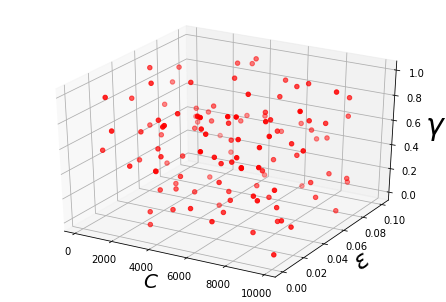

Best value iteration # 0 = 0.001041

[3.16305427e+02 2.62708340e-03 3.08787971e-02]
316.3054273896388
0.002627083396603518
0.030878797063414107
Best value iteration # 1 = 0.001035

[3.36680469e+02 2.96392735e-03 3.32023109e-02]
336.6804691209966
0.0029639273470728434
0.033202310890000454
Best value iteration # 2 = 0.001029

[3.32037365e+02 2.98099804e-03 3.22632502e-02]
332.03736530988255
0.0029809980404476824
0.03226325019088809
Best value iteration # 3 = 0.001029

[3.32037365e+02 2.98099804e-03 3.22632502e-02]
332.03736530988255
0.0029809980404476824
0.03226325019088809
Best value iteration # 4 = 0.000869

[3.57525436e+02 3.25983808e-03 3.57882390e-02]
357.52543570731956
0.0032598380777673266
0.035788238956809444
Best value iteration # 5 = 0.000869

[3.57525436e+02 3.25983808e-03 3.57882390e-02]
357.52543570731956
0.0032598380777673266
0.035788238956809444
Best value iteration # 6 = 0.000869

[3.57525436e+02 3.25983808e-03 3.57882390e-02]
357.52543570731956
0.0032598380777673266
0.03

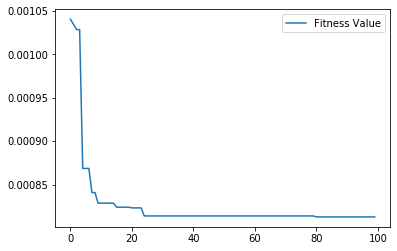

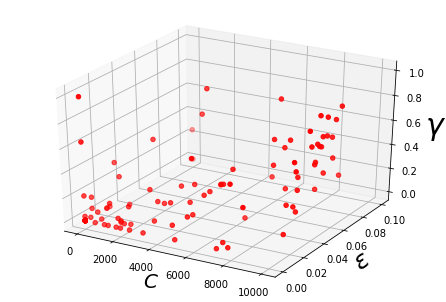

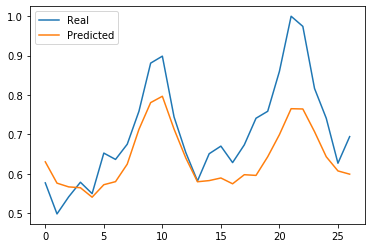

0.009467152505918465


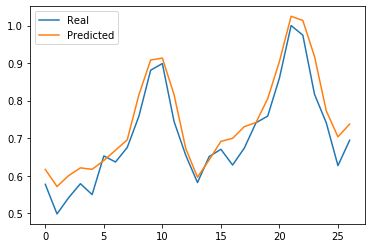

0.002292626483054701


In [21]:
pso(120, 100, 3, 1)

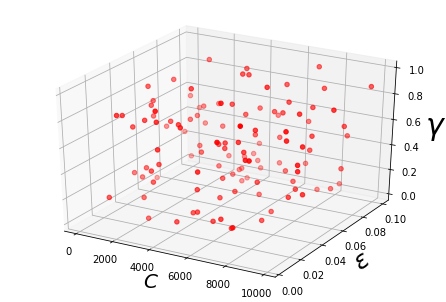

Best value iteration # 0 = 0.000917

[2.43225724e+02 1.51561493e-03 1.89354924e-02]
243.22572377102614
0.0015156149324493935
0.018935492369040626
Best value iteration # 1 = 0.000821

[1.96591235e+02 1.56727836e-03 1.56307576e-02]
196.59123456977767
0.0015672783550052588
0.015630757560969318
Best value iteration # 2 = 0.000781

[1.96600281e+02 1.56811169e-03 1.89274981e-02]
196.6002811403454
0.001568111688338592
0.018927498148757438
Best value iteration # 3 = 0.000781

[1.96600281e+02 1.56811169e-03 1.89274981e-02]
196.6002811403454
0.001568111688338592
0.018927498148757438
Best value iteration # 4 = 0.000781

[1.96600281e+02 1.56811169e-03 1.89274981e-02]
196.6002811403454
0.001568111688338592
0.018927498148757438
Best value iteration # 5 = 0.000781

[1.96600281e+02 1.56811169e-03 1.89274981e-02]
196.6002811403454
0.001568111688338592
0.018927498148757438
Best value iteration # 6 = 0.000781

[1.96600281e+02 1.56811169e-03 1.89274981e-02]
196.6002811403454
0.001568111688338592
0.0189274

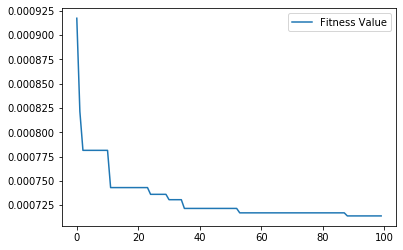

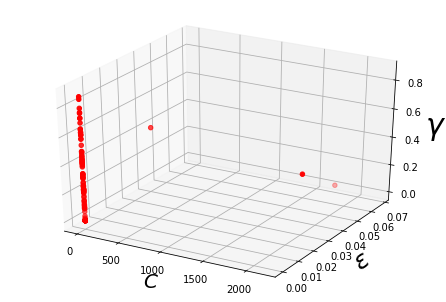

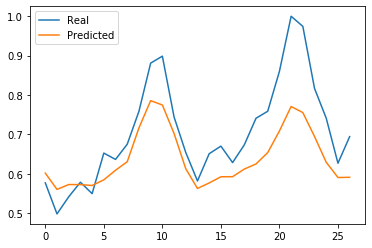

0.009143264901598792


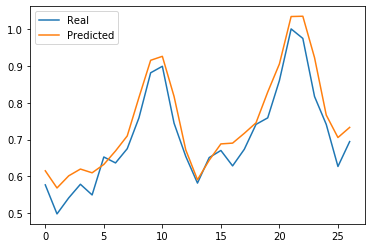

0.002431721711757021


In [23]:
pso(120, 100, 3, 0.8)

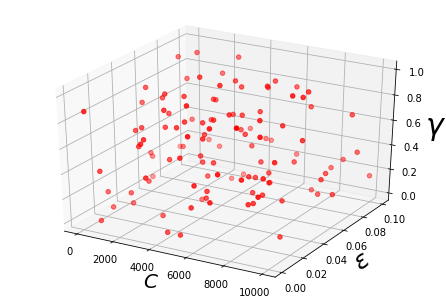

Best value iteration # 0 = 0.000880

[2.72027714e+02 1.49075664e-03 2.39574989e-02]
272.02771433796846
0.0014907566378253357
0.023957498892866635
Best value iteration # 1 = 0.000868

[2.26024686e+02 1.49336320e-03 2.60662372e-02]
226.02468566520386
0.0014933631979566306
0.026066237188856752
Best value iteration # 2 = 0.000855

[2.35649559e+02 1.49281785e-03 2.56250415e-02]
235.64955949644408
0.0014928178466369227
0.025625041453976247
Best value iteration # 3 = 0.000853

[2.55327497e+02 1.77187622e-03 3.03164438e-02]
255.32749679166562
0.0017718762230164338
0.030316443750621966
Best value iteration # 4 = 0.000835

[2.56768934e+02 1.77577228e-03 3.12708220e-02]
256.7689342114211
0.0017757722757617601
0.031270821992465496
Best value iteration # 5 = 0.000835

[2.56768934e+02 1.77577228e-03 3.12708220e-02]
256.7689342114211
0.0017757722757617601
0.031270821992465496
Best value iteration # 6 = 0.000819

[2.45669524e+02 1.81057456e-03 3.02423328e-02]
245.66952447007557
0.001810574564743559
0.

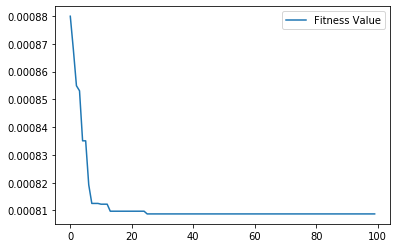

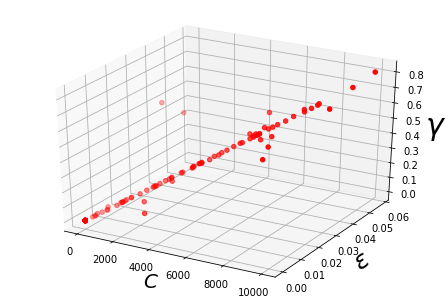

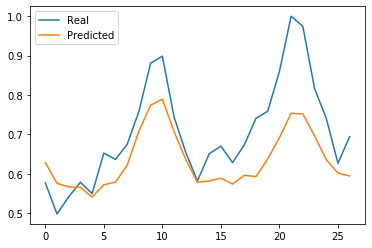

0.010396983317159821


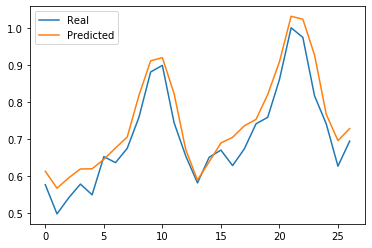

0.002514544005879423


In [24]:
pso(120, 100, 3, 0.6)

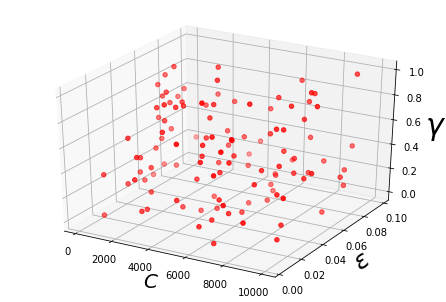

Best value iteration # 0 = 0.000841

[2.77039484e+02 2.82334722e-03 2.03984530e-02]
277.039483791681
0.002823347216980355
0.02039845299402428
Best value iteration # 1 = 0.000836

[2.68131156e+02 2.84007709e-03 2.11361077e-02]
268.1311564082092
0.002840077093802324
0.02113610770519144
Best value iteration # 2 = 0.000825

[2.66349491e+02 2.84342307e-03 2.12836386e-02]
266.3494909315148
0.002843423069166718
0.021283638647424875
Best value iteration # 3 = 0.000815

[3.09247408e+02 3.10196251e-03 2.68876276e-02]
309.24740784994515
0.0031019625114004938
0.026887627565680892
Best value iteration # 4 = 0.000815

[3.09247408e+02 3.10196251e-03 2.68876276e-02]
309.24740784994515
0.0031019625114004938
0.026887627565680892
Best value iteration # 5 = 0.000815

[3.09247408e+02 3.10196251e-03 2.68876276e-02]
309.24740784994515
0.0031019625114004938
0.026887627565680892
Best value iteration # 6 = 0.000815

[3.09247408e+02 3.10196251e-03 2.68876276e-02]
309.24740784994515
0.0031019625114004938
0.026887

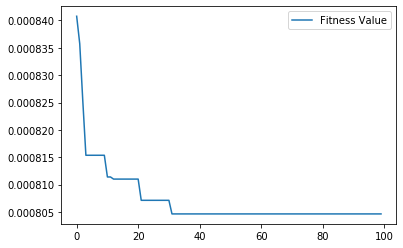

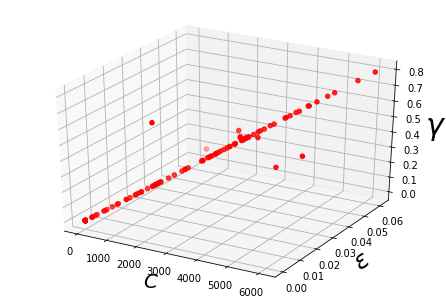

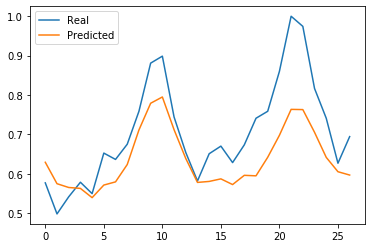

0.009684848827978947


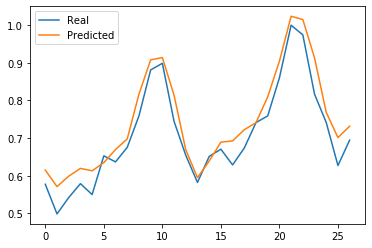

0.0021289602093419366


In [25]:
pso(120, 100, 3, 0.2)